In [1]:
import os
import openpyxl

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import statsmodels.api as sm

from glob import glob
from math import ceil, floor
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import RANSACRegressor, HuberRegressor, LinearRegression
from scipy.stats import pearsonr

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def simple_regplot(
    x, y, n_std=2, n_pts=100, ax=None, scatter_kws=None, line_kws=None, ci_kws=None
):
    """ Draw a regression line with error interval. """
    ax = plt.gca() if ax is None else ax

    # calculate best-fit line and interval
    x_fit = sm.add_constant(x)
    fit_results = sm.OLS(y, x_fit).fit()

    eval_x = sm.add_constant(np.linspace(np.min(x), np.max(x), n_pts))
    pred = fit_results.get_prediction(eval_x)

    # draw the fit line and error interval
    ci_kws = {} if ci_kws is None else ci_kws
    ax.fill_between(
        eval_x[:, 1],
        pred.predicted_mean - n_std * pred.se_mean,
        pred.predicted_mean + n_std * pred.se_mean,
        alpha=0.5,
        **ci_kws,
    )
    line_kws = {} if line_kws is None else line_kws
    h = ax.plot(eval_x[:, 1], pred.predicted_mean, **line_kws)

    # draw the scatterplot
    scatter_kws = {} if scatter_kws is None else scatter_kws
    ax.scatter(x, y, c=h[0].get_color(), **scatter_kws)

    return fit_results    


def calibrate_branch_trait(field_measurement_df, sensor_measurement_df):

    valid_sensor_measurement_df = sensor_measurement_df.copy()
    for row in field_measurement_df.iterrows():
        section_idx, color, vertical_angle, branch_diameter = row[1][['Section Index', 'Color', 'Crotch Angle/°', 'Diameter/mm']]
        valid_sensor_measurement_df.loc[(valid_sensor_measurement_df['Section_Index']==section_idx)&(valid_sensor_measurement_df['Color']==color), ['Manual_Vertical_Crotch_Angle-Degree']] = vertical_angle
        valid_sensor_measurement_df.loc[(valid_sensor_measurement_df['Section_Index']==section_idx)&(valid_sensor_measurement_df['Color']==color), ['Manual_Branch_Diameter-mm']] = branch_diameter

    return valid_sensor_measurement_df


def plot_best_ransac_fit(x, y):
    
    x = x.values.reshape(-1, 1)
    y = y.values.reshape(-1, 1)

    ransac = RANSACRegressor()
    ransac.fit(x, y)

    line_X = np.arange(x.min(), x.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)

    return line_X, line_y_ransac, ransac.estimator_.coef_, ransac.estimator_.intercept_, ransac.score(x, y)


def plot_linear_fit(x, y, fit_intercept=True):
    
    x = x.values.reshape(-1, 1)
    y = y.values.reshape(-1, 1)

    reg = LinearRegression(fit_intercept=fit_intercept)
    reg.fit(x, y)

    line_X = np.arange(x.min(), x.max())[:, np.newaxis]
    line_y = reg.predict(line_X)

    return line_X, line_y, reg.coef_, reg.intercept_, reg.score(x, y)  


def calibrate_branch_trait_from_other_excel(sensor_measurement_df, field_measurement_df):

    tmp_df = sensor_measurement_df.loc[~sensor_measurement_df['Label'].isnull(), :]
    valid_sensor_measurement_df = tmp_df.copy()
    valid_sensor_measurement_df['Section_Index'] = valid_sensor_measurement_df['Label'].apply(lambda x: int(x.split('_')[0][-1]))
    valid_sensor_measurement_df['Color'] = valid_sensor_measurement_df['Label'].apply(lambda x: x.split('_')[1])
    calibrated_sensor_measurement_df = calibrate_branch_trait(field_measurement_df, valid_sensor_measurement_df)
    
    return calibrated_sensor_measurement_df  


def evaluation(sensor_measurement, x, y):
    estimation = sensor_measurement[x]
    gt = sensor_measurement[y]

    mae = round(mean_absolute_error(gt, estimation), 2)
    mape = round(mean_absolute_percentage_error(gt, estimation), 2)
    rmse = round(mean_squared_error(gt, estimation, squared=False), 2)
    lr_x, lr_y, lr_coef, lr_intercept, lr_score = plot_linear_fit(estimation, gt, fit_intercept=True)
    ransac_lr_x, ransac_lr_y, coef, intercept, score = plot_best_ransac_fit(estimation, gt)

    return {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'LR': [lr_x, lr_y, lr_coef, lr_intercept, lr_score],
        'RLR': [ransac_lr_x, ransac_lr_y, coef, intercept, score]
    }

In [3]:
field_measurement_filepath = Path(r"D:\Data\Apple_Orchard\Lailiang_Cheng\Field_Measurements.xlsx")

data_folder = Path(r'D:\Code\Apple_Crop_Potential_Prediction\data\characterization')
exp_id =  'characterization_final'
data_folder = data_folder / exp_id
excel_files = sorted(glob(str(data_folder / 'tree*.xlsx')))

save_folder = data_folder / 'all_characterization'
save_folder.mkdir(exist_ok=True)

In [4]:
all_tree_df = None
all_sensor_measurement = 0
all_field_measurement = 0

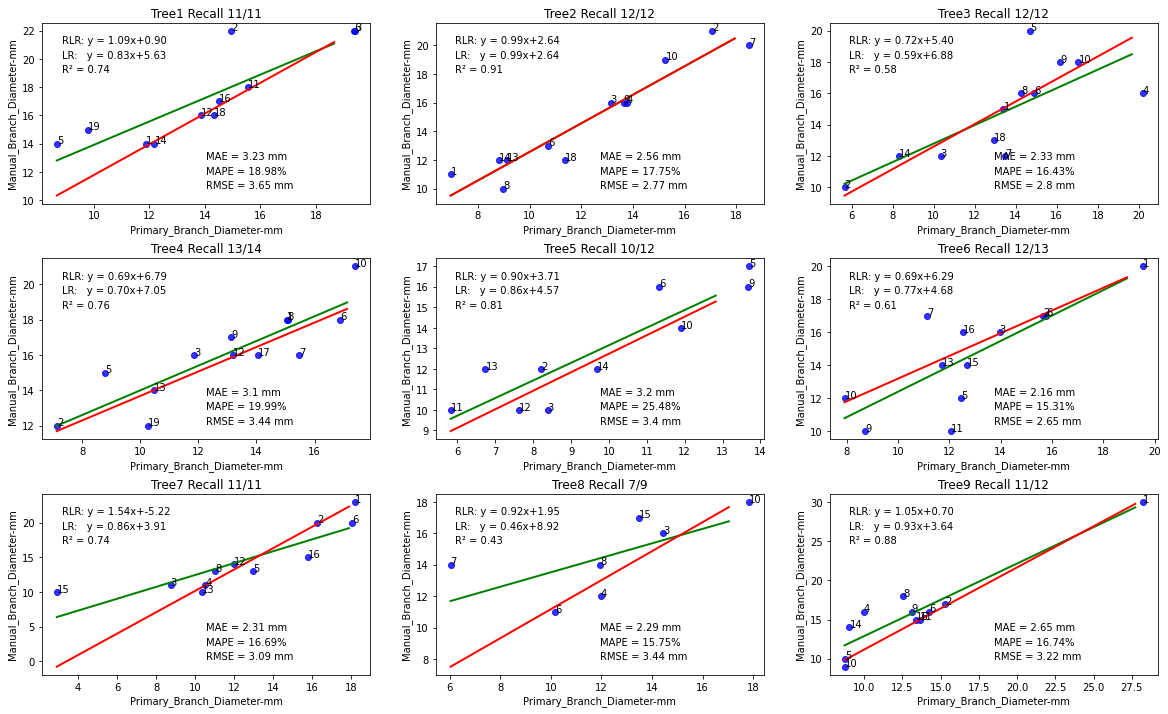

In [5]:
x_axis = 'Primary_Branch_Diameter-mm' # 'Manual_Vertical_Crotch_Angle-Degree'
y_axis = 'Manual_Branch_Diameter-mm'  # 'Vertical_Croth_Angle-Degree'

nrows = 3
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
plt.subplots_adjust(wspace=None, hspace=0.3)


for index, characterization_filepath in enumerate(excel_files[:]):

    row = index // ncols
    col = index % ncols
    ax = axs[row, col]

    tree_id = Path(characterization_filepath).stem
    tree_id = tree_id.split('_')[0]

    field_measurement_df = pd.read_excel(field_measurement_filepath, sheet_name=tree_id.capitalize())

    characterization_excel = openpyxl.load_workbook(str(characterization_filepath))
    calibrated_sensor_measurement_gt = None

    sheetname = characterization_excel.sheetnames[0]
    sensor_measurement_df = pd.read_excel(str(characterization_filepath), sheet_name=sheetname)
    calibrated_sensor_measurement_df = calibrate_branch_trait_from_other_excel(sensor_measurement_df, field_measurement_df)

    sensor_measurement_df_reset = sensor_measurement_df.set_index('Branch ID')
    calibrated_sensor_measurement_df_reset = calibrated_sensor_measurement_df.set_index('Branch ID')
    sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']] = calibrated_sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']]

    tmp = sensor_measurement_df_reset.loc[~sensor_measurement_df_reset[y_axis].isnull(), :]
    valid_sensor_measurement_df = tmp.copy()
    valid_sensor_measurement_df['Primary_Branch_Diameter-mm'] = valid_sensor_measurement_df['Primary_Branch_Radius-mm'] * 2
    total_sensor_measurement = len(valid_sensor_measurement_df)
    total_field_measurement = len(field_measurement_df) - 1

    if all_tree_df is None:
        all_tree_df = valid_sensor_measurement_df
    else:
        all_tree_df = pd.concat([all_tree_df, valid_sensor_measurement_df])

    all_sensor_measurement = all_sensor_measurement + total_sensor_measurement
    all_field_measurement = all_field_measurement + total_field_measurement

    metrics = evaluation(valid_sensor_measurement_df, x=x_axis, y=y_axis)
    lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
    ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
    sns.regplot(x=x_axis, y=y_axis, data=valid_sensor_measurement_df, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
    ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
    ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="RANSAC regressor")
    
    for row in valid_sensor_measurement_df.iterrows():
        tmp_est = row[1][x_axis]
        tmp_gt = row[1][y_axis]
        ax.text(tmp_est, tmp_gt, row[0])

    ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0][0]:.2f}x+{rlr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.06, 0.74, f'R\u00b2 = {lr_score:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)    
    ax.text(0.5, 0.26, f"MAE = {metrics['MAE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, 0.18, f"MAPE = {metrics['MAPE']}%", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, 0.1, f"RMSE = {metrics['RMSE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.set_title(f'{tree_id.capitalize()} Recall {total_sensor_measurement}/{total_field_measurement}')

plt.savefig(str(save_folder / 'Diameter.png'), dpi=300)

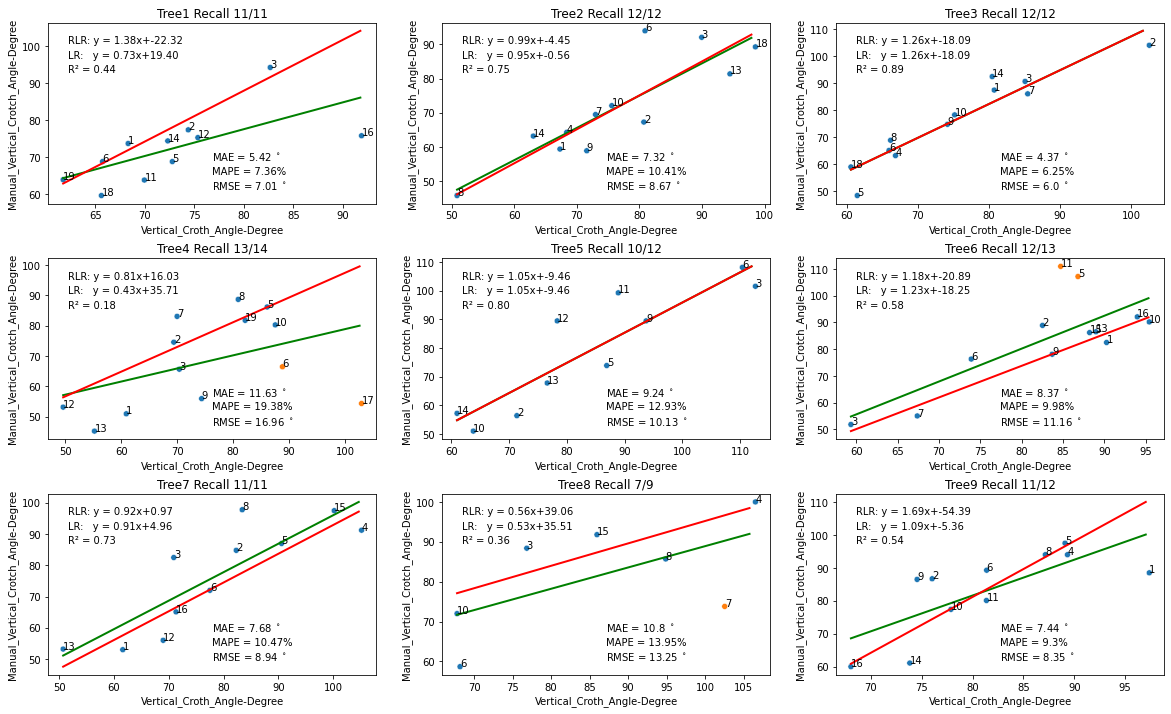

In [6]:
x_axis = 'Vertical_Croth_Angle-Degree'
y_axis = 'Manual_Vertical_Crotch_Angle-Degree'

nrows = 3
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
plt.subplots_adjust(wspace=None, hspace=0.3)


for index, characterization_filepath in enumerate(excel_files[:]):

    row = index // ncols
    col = index % ncols
    ax = axs[row, col]

    tree_id = Path(characterization_filepath).stem
    tree_id = tree_id.split('_')[0]

    field_measurement_df = pd.read_excel(field_measurement_filepath, sheet_name=tree_id.capitalize())

    characterization_excel = openpyxl.load_workbook(str(characterization_filepath))
    calibrated_sensor_measurement_gt = None

    sheetname = characterization_excel.sheetnames[0]
    sensor_measurement_df = pd.read_excel(str(characterization_filepath), sheet_name=sheetname)
    calibrated_sensor_measurement_df = calibrate_branch_trait_from_other_excel(sensor_measurement_df, field_measurement_df)

    sensor_measurement_df_reset = sensor_measurement_df.set_index('Branch ID')
    calibrated_sensor_measurement_df_reset = calibrated_sensor_measurement_df.set_index('Branch ID')
    sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']] = calibrated_sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']]

    tmp = sensor_measurement_df_reset.loc[~sensor_measurement_df_reset['Manual_Branch_Diameter-mm'].isnull(), :]
    valid_sensor_measurement_df = tmp.copy()
    valid_sensor_measurement_df['Primary_Branch_Diameter-mm'] = valid_sensor_measurement_df['Primary_Branch_Radius-mm'] * 2
    total_sensor_measurement = len(valid_sensor_measurement_df)
    total_field_measurement = len(field_measurement_df) - 1

    # highlight angle error > 20 degree data points
    valid_sensor_measurement_df['Outlier'] = 0
    valid_sensor_measurement_df.loc[abs(valid_sensor_measurement_df[x_axis]-valid_sensor_measurement_df[y_axis]) > 20, 'Outlier'] = 1

    metrics = evaluation(valid_sensor_measurement_df, x=x_axis, y=y_axis)
    lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
    ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
    sns.regplot(x=x_axis, y=y_axis, data=valid_sensor_measurement_df, scatter=False, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
    sns.scatterplot(x=x_axis, y=y_axis, data=valid_sensor_measurement_df, hue='Outlier', legend=False, ax=ax)
    ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
    ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="RANSAC regressor")

    for row in valid_sensor_measurement_df.iterrows():
        tmp_est = row[1][x_axis]
        tmp_gt = row[1][y_axis]
        ax.text(tmp_est, tmp_gt, row[0])

    ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0][0]:.2f}x+{rlr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.06, 0.74, f'R\u00b2 = {lr_score:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)    
    ax.text(0.5, 0.26, f"MAE = {metrics['MAE']} $^\circ$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, 0.18, f"MAPE = {metrics['MAPE']}%", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, 0.1, f"RMSE = {metrics['RMSE']} $^\circ$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.set_title(f'{tree_id.capitalize()} Recall {total_sensor_measurement}/{total_field_measurement}')

plt.savefig(str(save_folder / 'Angle.png'), dpi=300)

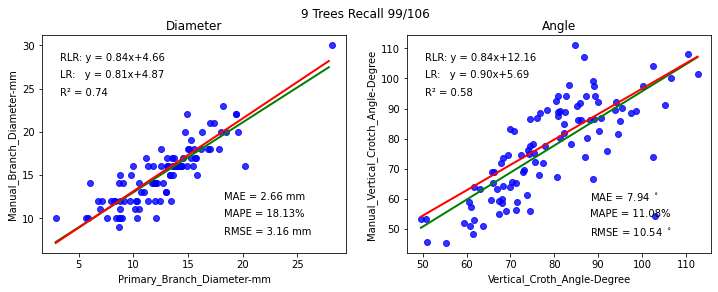

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax = axes[0]
x_axis = 'Primary_Branch_Diameter-mm' # 'Manual_Vertical_Crotch_Angle-Degree'
y_axis = 'Manual_Branch_Diameter-mm'  # 'Vertical_Croth_Angle-Degree'
metrics = evaluation(all_tree_df, x=x_axis, y=y_axis)
lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
sns.regplot(x=x_axis, y=y_axis, data=all_tree_df, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="RANSAC regressor")
ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0][0]:.2f}x+{rlr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.06, 0.74, f'R\u00b2 = {lr_score:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)    
ax.text(0.6, 0.26, f"MAE = {metrics['MAE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.6, 0.18, f"MAPE = {metrics['MAPE']}%", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.6, 0.1, f"RMSE = {metrics['RMSE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.set_title('Diameter')

ax = axes[1]
x_axis = 'Vertical_Croth_Angle-Degree'
y_axis = 'Manual_Vertical_Crotch_Angle-Degree'
metrics = evaluation(all_tree_df, x=x_axis, y=y_axis)
lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
sns.regplot(x=x_axis, y=y_axis, data=all_tree_df, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="RANSAC regressor")
ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0][0]:.2f}x+{rlr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.06, 0.74, f'R\u00b2 = {lr_score:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)    
ax.text(0.6, 0.26, f"MAE = {metrics['MAE']} $^\circ$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.6, 0.18, f"MAPE = {metrics['MAPE']}%", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.6, 0.1, f"RMSE = {metrics['RMSE']} $^\circ$", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.set_title('Angle')

fig.suptitle(f'9 Trees Recall {all_sensor_measurement}/{all_field_measurement}')
plt.savefig(str(save_folder / 'All_New.png'), dpi=300)

In [9]:
all_tree_df.to_csv(str(save_folder / 'all_tree.csv'))

Text(0.5, 0.98, 'Tree4 Recall 13/14')

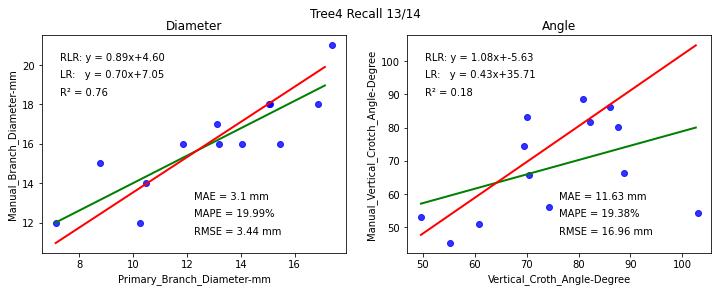

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

characterization_filepath = excel_files[3]

tree_id = Path(characterization_filepath).stem
tree_id = tree_id.split('_')[0]

field_measurement_df = pd.read_excel(field_measurement_filepath, sheet_name=tree_id.capitalize())

characterization_excel = openpyxl.load_workbook(str(characterization_filepath))
calibrated_sensor_measurement_gt = None

sheetname = characterization_excel.sheetnames[0]
sensor_measurement_df = pd.read_excel(str(characterization_filepath), sheet_name=sheetname)
calibrated_sensor_measurement_df = calibrate_branch_trait_from_other_excel(sensor_measurement_df, field_measurement_df)

sensor_measurement_df_reset = sensor_measurement_df.set_index('Branch ID')
calibrated_sensor_measurement_df_reset = calibrated_sensor_measurement_df.set_index('Branch ID')
sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']] = calibrated_sensor_measurement_df_reset[['Manual_Vertical_Crotch_Angle-Degree', 'Manual_Branch_Diameter-mm']]

tmp = sensor_measurement_df_reset.loc[~sensor_measurement_df_reset['Manual_Branch_Diameter-mm'].isnull(), :]
valid_sensor_measurement_df = tmp.copy()
valid_sensor_measurement_df['Primary_Branch_Diameter-mm'] = valid_sensor_measurement_df['Primary_Branch_Radius-mm'] * 2
total_sensor_measurement = len(valid_sensor_measurement_df)
total_field_measurement = len(field_measurement_df) - 1

ax = axes[0]
x_axis = 'Primary_Branch_Diameter-mm' # 'Manual_Vertical_Crotch_Angle-Degree'
y_axis = 'Manual_Branch_Diameter-mm'  # 'Vertical_Croth_Angle-Degree'
metrics = evaluation(valid_sensor_measurement_df, x=x_axis, y=y_axis)
lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
sns.regplot(x=x_axis, y=y_axis, data=valid_sensor_measurement_df, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="RANSAC regressor")
ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0][0]:.2f}x+{rlr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.06, 0.74, f'R\u00b2 = {lr_score:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)    
ax.text(0.5, 0.26, f"MAE = {metrics['MAE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5, 0.18, f"MAPE = {metrics['MAPE']}%", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5, 0.1, f"RMSE = {metrics['RMSE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.set_title('Diameter')

ax = axes[1]
x_axis = 'Vertical_Croth_Angle-Degree'
y_axis = 'Manual_Vertical_Crotch_Angle-Degree'
metrics = evaluation(valid_sensor_measurement_df, x=x_axis, y=y_axis)
lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
sns.regplot(x=x_axis, y=y_axis, data=valid_sensor_measurement_df, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="RANSAC regressor")
ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0][0]:.2f}x+{rlr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.06, 0.74, f'R\u00b2 = {lr_score:.2f}', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)    
ax.text(0.5, 0.26, f"MAE = {metrics['MAE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5, 0.18, f"MAPE = {metrics['MAPE']}%", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5, 0.1, f"RMSE = {metrics['RMSE']} mm", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.set_title('Angle')

fig.suptitle(f'{tree_id.capitalize()} Recall {total_sensor_measurement}/{total_field_measurement}')
# plt.savefig(str(save_folder / tree_id.capitalize()))

In [43]:
valid_sensor_measurement_df

,Filename,Vertical_Croth_Angle-Degree,Primary_Branch_Radius-mm,Manual_Vertical_Crotch_Angle-Degree,Manual_Branch_Diameter-mm,Primary_Branch_Diameter-mm
Branch ID,,,,,,
2,tree4,62.27,8.09,51.0,18.0,16.18
3,tree4,70.22,4.07,74.6,12.0,8.14
4,tree4,70.08,6.03,65.7,16.0,12.06
6,tree4,85.65,5.13,86.2,15.0,10.26
7,tree4,69.90,7.63,83.1,16.0,15.26
8,tree4,90.67,8.44,66.5,18.0,16.88
9,tree4,82.85,7.35,88.7,18.0,14.70
10,tree4,73.78,6.43,56.0,17.0,12.86
11,tree4,85.98,8.00,80.3,21.0,16.00


In [32]:
valid_sensor_measurement_df.index

Int64Index([1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 15, 19], dtype='int64', name='Branch ID')